# linear regreesion（Hồi quy tuyến tính）
python 3.6，
TensorFlow：pip install tensorflow

In [43]:
import pandas as pd
import seaborn as sns
sns.set(context="notebook", style="whitegrid", palette="dark")
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np


In [2]:
df = pd.read_csv('ex1data1.txt', names=['population', 'profit'])#Đọc dữ liệu và tên cột

In [4]:
df.head()#xem 5 dòng đầu tiên

,population,profit
0,6.1101,17.5920
1,5.5277,9.1302
2,8.5186,13.6620
3,7.0032,11.8540
4,5.8598,6.8233


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 2 columns):
population    97 non-null float64
profit        97 non-null float64
dtypes: float64(2)
memory usage: 1.6 KB


***
# Hãy xem dữ liệu thô

c:\program files\python37\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


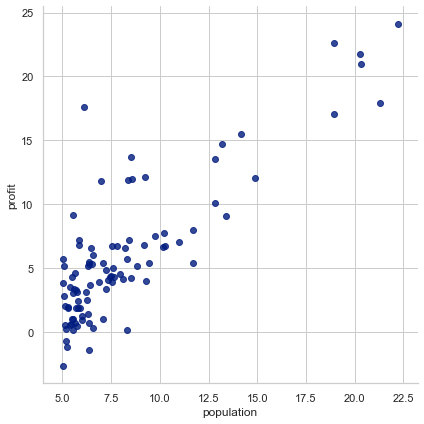

In [6]:
sns.lmplot('population', 'profit', df, size=6, fit_reg=False)
plt.show()

In [7]:
def get_X(df):#Đọc tính năng
#     """
#     use concat to add intersect feature to avoid side effect
#     not efficient for big dataset though
#     """
    ones = pd.DataFrame({'ones': np.ones(len(df))})#tạo 1 dataframe m hàng và 1 cột
    data = pd.concat([ones, df], axis=1)  # gộp dữ liệu theo cột
    return data.iloc[:, :-1].as_matrix()  # hàm trả về  ndarray,không phải là một ma trận


def get_y(df):#đọc lables
#     '''assume the last column is the target'''
    return np.array(df.iloc[:, -1])#df.iloc[:, -1] lấy cột cuối của dataframe


def normalize_feature(df):
#     """Applies function along input axis(default 0) of DataFrame."""
    return df.apply(lambda column: (column - column.mean()) / column.std())#特征缩放

Giả thuyết đa biến h được thể hiện là：\\[{{h}_{\theta }}\left( x \right)={{\theta }_{0}}+{{\theta }_{1}}{{x}_{1}}+{{\theta }_{2}}{{x}_{2}}+...+{{\theta }_{n}}{{x}_{n}}\\] 
Có n + 1 tham số và n biến trong công thức này, để làm cho công thức dễ dàng hơn,đặt${{x}_{0}}=1$，công thức được chuyển thành：  
Tại thời điểm này, tham số trong mô hình là một vectơ n + 1 chiều，Bất kỳ trường hợp đào tạo nào cũng là một vectơ có kích thước n + 1，Kích thước của ma trận tính năng X là m * (n + 1)。 Vì vậy, công thức có thể được đơn giản hóa để：${{h}_{\theta }}\left( x \right)={{\theta }^{T}}X$，Trong đó theta T đại diện cho ma trận chuyển vị。


In [10]:
def linear_regression(X_data, y_data, alpha, epoch, optimizer=tf.optimizers.SGD):#  
      # placeholder for graph input
    X = tf.placeholder(tf.float32, shape=X_data.shape)
    y = tf.placeholder(tf.float32, shape=y_data.shape)

    # construct the graph
    with tf.variable_scope('linear-regression'):
        W = tf.get_variable("weights",
                            (X_data.shape[1], 1),
                            initializer=tf.constant_initializer())  # n*1

        y_pred = tf.matmul(X, W)  # m*n @ n*1 -> m*1

        loss = 1 / (2 * len(X_data)) * tf.matmul((y_pred - y), (y_pred - y), transpose_a=True)  # (m*1).T @ m*1 = 1*1

    opt = optimizer(learning_rate=alpha)
    opt_operation = opt.minimize(loss)

    # run the session
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        loss_data = []

        for i in range(epoch):
            _, loss_val, W_val = sess.run([opt_operation, loss, W], feed_dict={X: X_data, y: y_data})
            loss_data.append(loss_val[0, 0])  # because every loss_val is 1*1 ndarray

            if len(loss_data) > 1 and np.abs(loss_data[-1] - loss_data[-2]) < 10 ** -9:  # early break when it's converged
                # print('Converged at epoch {}'.format(i))
                break

    # clear the graph
    tf.reset_default_graph()
    return {'loss': loss_data, 'parameters': W_val}  # just want to return in row vector format

In [57]:
data = pd.read_csv('ex1data1.txt', names=['population', 'profit'])#Đọc dữ liệu và đặt tên cột

data.head()

,population,profit
0,6.1101,17.5920
1,5.5277,9.1302
2,8.5186,13.6620
3,7.0032,11.8540
4,5.8598,6.8233


# Loss function
$$J\left( \theta  \right)=\frac{1}{2m}\sum\limits_{i=1}^{m}{{{\left( {{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}} \right)}^{2}}}$$
Trong đó：\\[{{h}_{\theta }}\left( x \right)={{\theta }^{T}}X={{\theta }_{0}}{{x}_{0}}+{{\theta }_{1}}{{x}_{1}}+{{\theta }_{2}}{{x}_{2}}+...+{{\theta }_{n}}{{x}_{n}}\\] 

In [58]:
X = get_X(data)
print(X.shape, type(X))

y = get_y(data)
print(y.shape, type(y))
#Xem kiểu dữ liệu

(97, 2) <class 'numpy.ndarray'>
(97,) <class 'numpy.ndarray'>


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [59]:
theta = np.zeros(X.shape[1])#X.shape[1]=2,代表特征数n

In [68]:
print(type(theta))

<class 'numpy.ndarray'>


In [14]:
def lr_cost(theta, X, y):
#     """
#     X: R(m*n), m mẫu, n thuộc tính
#     y: R(m)
#     theta : R(n), các tham số cho hồi quy tuyến tính
#     """
    m = X.shape[0]#m là số lượng mẫu

    inner = X @ theta - y  # R(m*1)，X @ theta tương đương vớiX.dot(theta)

    # 1*m @ m*1 = 1*1 in matrix multiplication
    # but you know numpy didn't do transpose in 1d array, so here is just a
    # vector inner product to itselves
    square_sum = inner.T @ inner
    cost = square_sum / (2 * m)

    return cost

In [15]:
lr_cost(theta, X, y)#trả về giá trị của theta

32.072733877455676

# batch gradient decent
$${{\theta }_{j}}:={{\theta }_{j}}-\alpha \frac{\partial }{\partial {{\theta }_{j}}}J\left( \theta  \right)$$

In [16]:
def gradient(theta, X, y):
    m = X.shape[0]

    inner = X.T @ (X @ theta - y)  # (m,n).T @ (m, 1) -> (n, 1)，X @ theta tương đương X.dot(theta)

    return inner / m

In [17]:
def batch_gradient_decent(theta, X, y, epoch, alpha=0.01):
#     epoch: 
#     """
    cost_data = [lr_cost(theta, X, y)]
    _theta = theta.copy()  

    for _ in range(epoch):
        _theta = _theta - alpha * gradient(_theta, X, y)
        cost_data.append(lr_cost(_theta, X, y))

    return _theta, cost_data


In [18]:
epoch = 500
final_theta, cost_data = batch_gradient_decent(theta, X, y, epoch)

In [19]:
final_theta


array([-2.28286727,  1.03099898])

In [20]:
cost_data


[32.072733877455676,
 6.737190464870011,
 5.931593568604956,
 5.901154707081388,
 5.895228586444221,
 5.890094943117332,
 5.885004158443646,
 5.8799324804914175,
 5.874879094762575,
 5.869843911806386,
 5.864826865312929,
 5.859827889932181,
 5.85484692057229,
 5.849883892376587,
 5.844938740722034,
 5.840011401218361,
 5.8351018097072265,
 5.830209902261388,
 5.825335615183862,
 5.820478885007098,
 5.815639648492155,
 5.810817842627869,
 5.806013404630045,
 5.80122627194063,
 5.796456382226899,
 5.791703673380653,
 5.7869680835173956,
 5.782249550975539,
 5.777548014315596,
 5.772863412319382,
 5.768195683989214,
 5.76354476854712,
 5.758910605434049,
 5.754293134309077,
 5.749692295048629,
 5.745108027745684,
 5.740540272709012,
 5.735988970462381,
 5.731454061743792,
 5.726935487504702,
 5.722433188909257,
 5.717947107333529,
 5.71347718436475,
 5.709023361800549,
 5.704585581648199,
 5.700163786123856,
 5.695757917651815,
 5.691367918863752,
 5.686993732597982,
 5.682635301898707,


In [21]:
# Tính chi phí cuối cùng

lr_cost(final_theta, X, y)

4.713809531116866

# visualize cost data

c:\program files\python37\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


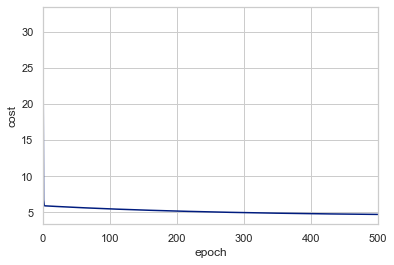

In [22]:
ax = sns.tsplot(cost_data, time=np.arange(epoch+1))
ax.set_xlabel('epoch')
ax.set_ylabel('cost')
plt.show()
#Bạn có thể thấy rằng dữ liệu chi phí đã thay đổi rất nhiều từ vòng thứ hai, và sau đó nó ổn định.

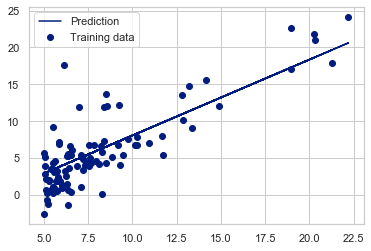

In [23]:
b = final_theta[0] # intercept，
m = final_theta[1] # slope

plt.scatter(data.population, data.profit, label="Training data")
plt.plot(data.population, data.population*m + b, label="Prediction")
plt.legend(loc=2)
plt.show()

# 3- Phần tự chọn

In [24]:
raw_data = pd.read_csv('ex1data2.txt', names=['square', 'bedrooms', 'price'])
raw_data.head()

,square,bedrooms,price
0,2104,3,399900
1,1600,3,329900
2,2400,3,369000
3,1416,2,232000
4,3000,4,539900


# Dữ liệu chuẩn
Là phương pháp co giãn các thuộc tính về khoảng [min,max][min,max] nào đó (thường là [-1,1][−1,1] hoặc [-0.5,0.5][−0.5,0.5]) dựa vào kì vọng và độ lệch chuẩn của chúng.

	

Giá trị trung bình và sn là độ lệch chuẩn.


In [70]:
def normalize_feature(df):# Chuẩn hóa đầu vào 
#     """Applies function along input axis(default 0) of DataFrame."""
    return df.apply(lambda column: (column - column.mean()) / column.std()) #column.mean(): trung bình 
                                                                            # column.std():Độ lệch chuẩn của tính năng

In [26]:
data = normalize_feature(raw_data)
data.head()

,square,bedrooms,price
0,0.130010,-0.223675,0.475747
1,-0.504190,-0.223675,-0.084074
2,0.502476,-0.223675,0.228626
3,-0.735723,-1.537767,-0.867025
4,1.257476,1.090417,1.595389


# 2. multi-var batch gradient decent


In [27]:
X = get_X(data)
print(X.shape, type(X))

y = get_y(data)
print(y.shape, type(y))#Nhìn vào kích thước và loại dữ liệu

(47, 3) <class 'numpy.ndarray'>
(47,) <class 'numpy.ndarray'>


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [28]:
alpha = 0.01#learning rate
theta = np.zeros(X.shape[1])#X.shape[1]：số lượng tính năng n
epoch = 500#số vòng

In [29]:
final_theta, cost_data = batch_gradient_decent(theta, X, y, epoch, alpha=alpha)

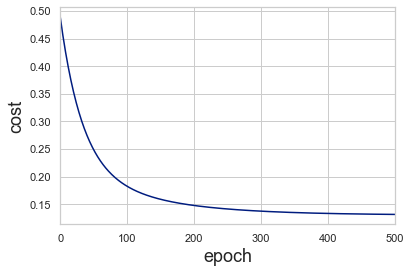

In [30]:
sns.tsplot(time=np.arange(len(cost_data)), data = cost_data)
plt.xlabel('epoch', fontsize=18)
plt.ylabel('cost', fontsize=18)
plt.show()

In [31]:
final_theta

array([-1.16537985e-16,  8.30383883e-01,  8.23982853e-04])

# 3. learning rate

In [32]:
base = np.logspace(-1, -5, num=4)
candidate = np.sort(np.concatenate((base, base*3)))
print(candidate)

[1.00000000e-05 3.00000000e-05 2.15443469e-04 6.46330407e-04
 4.64158883e-03 1.39247665e-02 1.00000000e-01 3.00000000e-01]


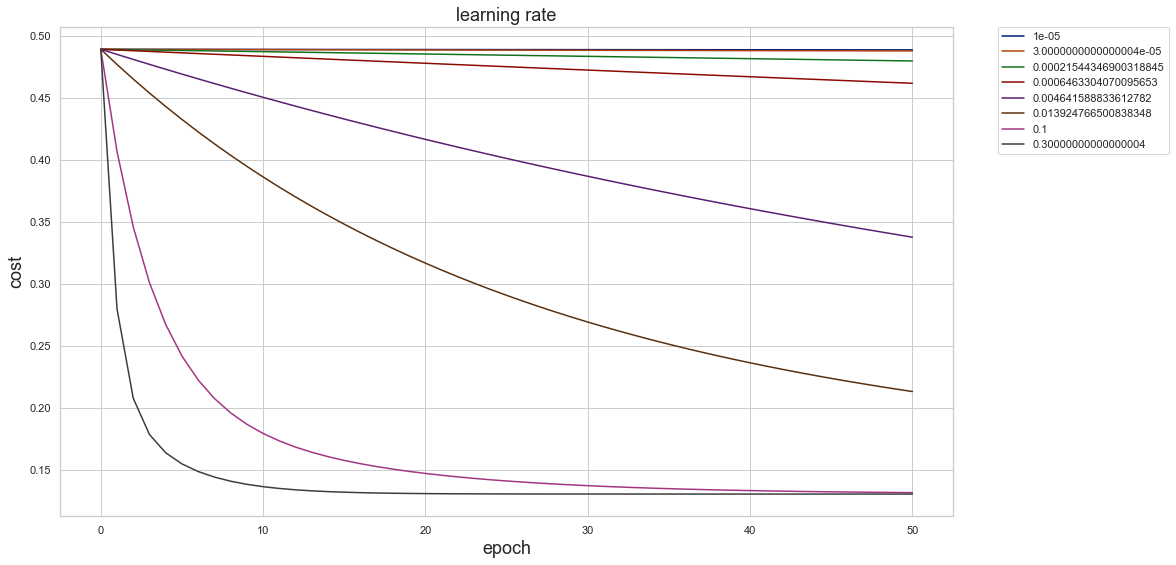

In [33]:
epoch=50

fig, ax = plt.subplots(figsize=(16, 9))

for alpha in candidate:
    _, cost_data = batch_gradient_decent(theta, X, y, epoch, alpha=alpha)
    ax.plot(np.arange(epoch+1), cost_data, label=alpha)

ax.set_xlabel('epoch', fontsize=18)
ax.set_ylabel('cost', fontsize=18)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_title('learning rate', fontsize=18)
plt.show()

# 4. normal equation（công thức chuẩn）
Công thức chuẩn là tìm tham số tối thiểu hóa hàm chi phí bằng cách giải phương trình sau：$\frac{\partial }{\partial {{\theta }_{j}}}J\left( {{\theta }_{j}} \right)=0$ 。
 Giả sử ma trận tính năng tập huấn luyện của chúng tôi là X（chứa${{x}_{0}}=1$）Và kết quả tập huấn luyện của chúng tôi là vectơ y，Sau đó sử dụng phương trình bình thường để giải vectơ $\theta ={{\left( {{X}^{T}}X \right)}^{-1}}{{X}^{T}}y$ 。
ký hiệu T nghĩa là chuyển vị，ký hiệu-1 là nghịch đảo。Hãy để ma trận $A={{X}^{T}}X$，sau đó：${{\left( {{X}^{T}}X \right)}^{-1}}={{A}^{-1}}$

So sánh độ dốc gốc và phương trình bình thường：

Độ dốc gốc: cần chọn tốc độ học tập α，Yêu cầu nhiều lần lặp. Nó cũng được áp dụng khi số lượng tính năng lớn, áp dụng cho các loại mô hình khác nhau

Phương trình bình thường: không cần chọn tỷ lệ học tập α，Tính một lần, cần tính.${{\left( {{X}^{T}}X \right)}^{-1}}$，Nếu số lượng tính năng n lớn, hoạt động tốn kém，Bởi vì độ phức tạp thời gian tính toán của nghịch đảo ma trận là O(n3)，Nói chung, khi n nhỏ hơn 10000 thì vẫn chấp nhận được. Nó chỉ phù hợp với các mô hình tuyến tính và không phù hợp với các mô hình khác như mô hình hồi quy logistic.



In [34]:
# Phương trình chuẩn
def normalEqn(X, y):
    theta = np.linalg.inv(X.T@X)@X.T@y#X.T@X tương đương với X.T.dot(X)
    return theta

In [35]:
final_theta2=normalEqn(X, y)#Nó cảm thấy một chút khác biệt với giá trị theta của giảm độ dốc hàng loạt
final_theta2

array([-1.11022302e-16,  8.84765988e-01, -5.31788197e-02])

# run the tensorflow graph over several optimizer

In [36]:
X_data = get_X(data)
print(X_data.shape, type(X_data))

y_data = get_y(data).reshape(len(X_data), 1)  # special treatment for tensorflow input data
print(y_data.shape, type(y_data))

(47, 3) <class 'numpy.ndarray'>
(47, 1) <class 'numpy.ndarray'>


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [37]:
epoch = 2000
alpha = 0.01

In [45]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [47]:
optimizer_dict={'GD': tf.train.GradientDescentOptimizer,
                'Adagrad': tf.train.AdagradOptimizer,
                'Adam': tf.train.AdamOptimizer,
                'Ftrl': tf.train.FtrlOptimizer,
                'RMS': tf.train.RMSPropOptimizer
               }
results = []
for name in optimizer_dict:
    res = linear_regression(X_data, y_data, alpha, epoch, optimizer=optimizer_dict[name])
    res['name'] = name
    results.append(res)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


# Vẽ

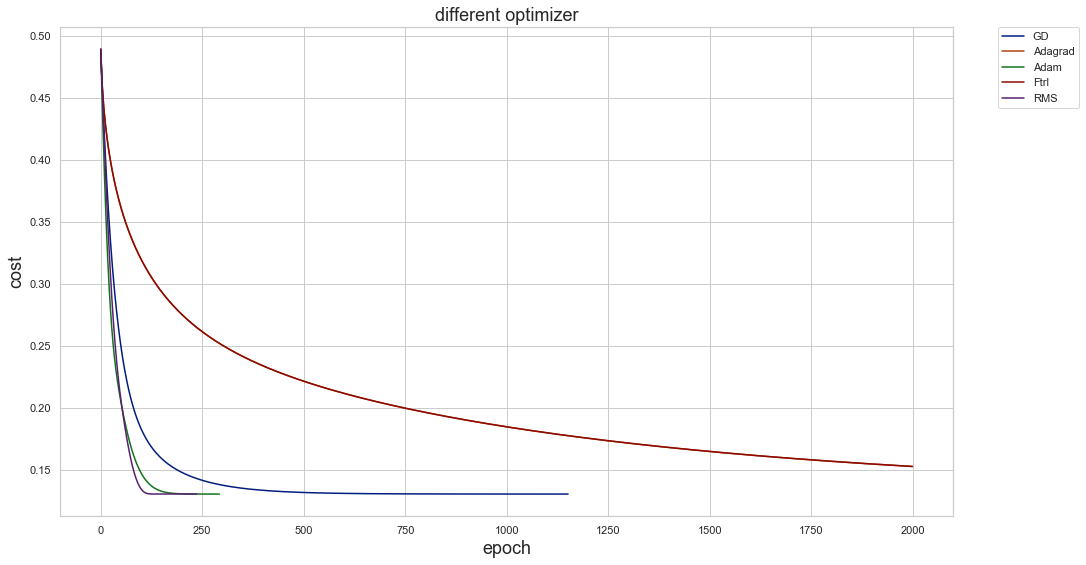

In [48]:
fig, ax = plt.subplots(figsize=(16, 9))

for res in results: 
    loss_data = res['loss']
    
#     print('for optimizer {}'.format(res['name']))
#     print('final parameters\n', res['parameters'])
#     print('final loss={}\n'.format(loss_data[-1]))
    ax.plot(np.arange(len(loss_data)), loss_data, label=res['name'])

ax.set_xlabel('epoch', fontsize=18)
ax.set_ylabel('cost', fontsize=18)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_title('different optimizer', fontsize=18)
plt.show()